## What can data science tell about New York City (NYC) subway use?

NYC subway is the busiest subway system in the United States and ranked as 7$^{th}$ busiest in the world! That means many people are using the subway, and it serves as an essential transportation pipeline. Thus, it is very useful and powerful if I can reveal causal relationship among the ridership and some factors or predict the ridership.

So what kinds of questions are people (or I) interested in? 
For examples, 
    - When do people use the subway ?
    - Do people use the subway more often when the weather is bad?
    - etc... 
    
There are numerous interesting questions you might have.

Here, I have weather data, collected by Wunderground. Given the data (weather & subway), I would like to explore what factors (rain, weekday, and what not) influece the subway usage.


Here is what kinds of data are contained in the file.

In [706]:
PDF('turnstile-weather-variables.pdf',size=(600,500))

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import scipy.stats as ss
import datetime 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import pprint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


###### import data

In [4]:
#import datasets
data = pd.read_csv('turnstile_weather_v2.csv')

In [5]:
#----clean some of the columns----
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%d %H:%M:%S')
#factorize the categorical values
data['station'], station_index = pd.factorize(data['station'])
data['conds'], conds_index = pd.factorize(data['conds'])
#-----------------------------------------

*turnstile_weather_v2.csv* contains both subway and weather data. Before processing data any further, I cleaned some of data a little so that it will be easier to work on later.


## Section1. Statistical Test

As a first step to examine the NYC subway usage, I try to see whether the distribution of ridership is similar between two conditions. As a side note, I use the following two words, the ridership and *ENTRIESn_hourly* (variable), interchangeably because *ENTRIESn_hourly* describes the number of passengers who have passed a particular turnstile. Thus, the larger the value of *ENTRIESn_hourly*  is, the more passangers have gone through. 

I chose to compare a condition to be rainy or not-rainy days. The comparioson questions whether there is any difference between the ridership between rainy and not-rainy days. Intuitively, I will imagine that if a day is rainy, many people may choose to take subway so that it will be less hassle for them to walk in rain. Thus, I suspect that the relationship between rain and the ridership is positively correlated (i.e. more rain = more riders).

To categorize whether the day is rainy or not, I group the data according to variable **rain**, where the rainy day is marked as 1, otherwise, 0. Before going into any analysis, I want to check the exsistence of any category other than {0,1} from **rain** . 

In [5]:
print set(data['rain'])

set([0, 1])


The above confirms that I will not leave any data point out by grouping the data based on *rain* = 1 (rain) and *rain* = 0 (no rain). Additionally, I have found out that one of *UNIT* only contains 0 for all *ENTRIESn_hourly*, which contributes nothing to the analysis. I am going to eliminate such *UNIT*.

In [6]:
#factorize the UNIT
UNIT, k = pd.factorize(data['UNIT'])

#unique set of UNIT
s = np.arange(len(set(UNIT)))


for ind, (c, i) in enumerate(data.groupby('UNIT')):
    s[ind] = i['ENTRIESn_hourly'].sum()

#threshold: total ridership < 100
eliminate = np.where((s < 100) == True)[0]
print 'UNIT to eliminate:',k[eliminate][:]

UNIT to eliminate: Index([u'R464'], dtype='object')


The below confirms that entries from R464 do not contain any information. 

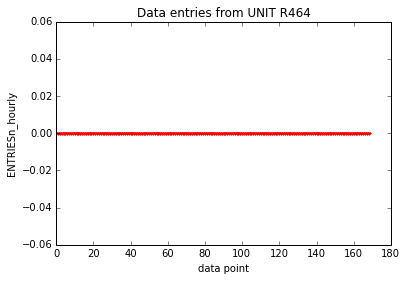

In [7]:
R464_ENTRIESn_hourly = data[data['UNIT'] == 'R464']['ENTRIESn_hourly'].values
plt.plot(np.arange(len(R464_ENTRIESn_hourly)),R464_ENTRIESn_hourly,'r.')
plt.xlabel('data point')
plt.ylabel('ENTRIESn_hourly')
plt.title('Data entries from UNIT R464')

I eliminated it.

In [8]:
#Elimination of R464
data = data[data['UNIT'] != 'R464']

After cleaning data, I compared the distributions of *ENTRIESn_hourly* between the two categories (rainy vs. not-rainy) as the follow.

###### Histogram: ENTRIESn_hourly $($rainy days vs. not-rainy days$)$ <a id='fig1'></a>

In [9]:
rain = data[data['rain'] == 1]['ENTRIESn_hourly'].values
no_rain = data[data['rain'] == 0]['ENTRIESn_hourly'].values

(0, 500)

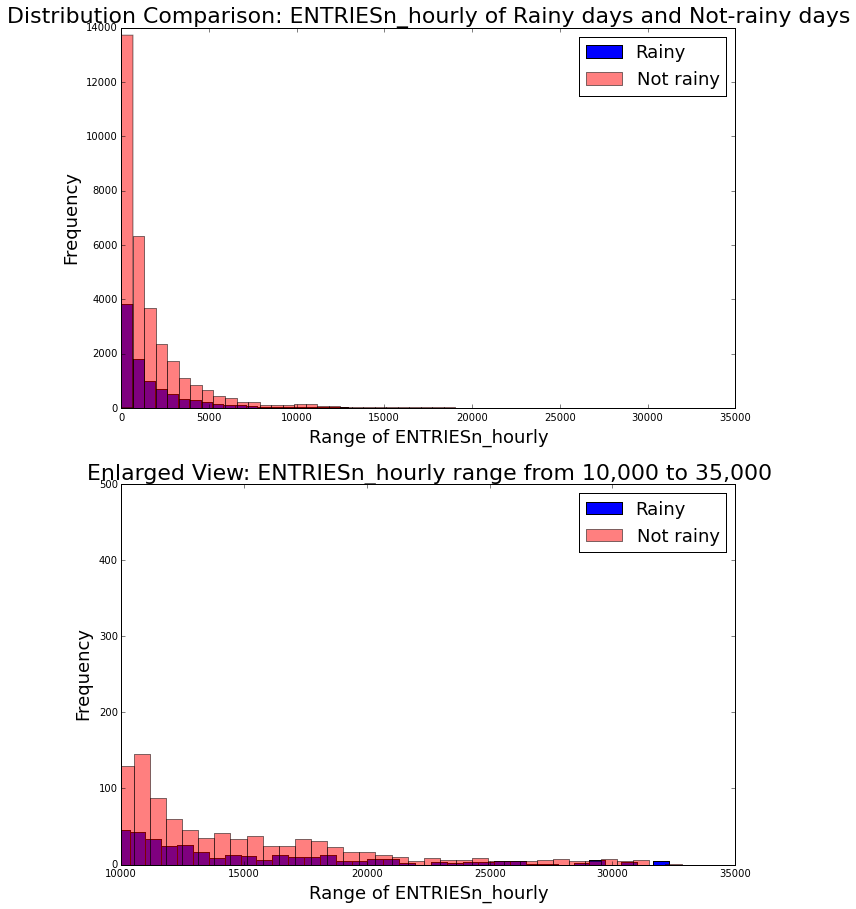

In [10]:
flag = False
fig, ax = plt.subplots(nrows=2, figsize = (11, 15))
ax[0].hist(rain,bins=50,normed=flag,color = 'b',label='Rainy')
ax[0].hist(no_rain,bins=50,normed=flag,color = 'r',alpha=0.5,label='Not rainy')
ax[0].legend(fontsize=18)
ax[0].set_xlabel('Range of ENTRIESn_hourly', fontsize=18)
ax[0].set_ylabel('Frequency', fontsize=18)
ax[0].set_title('Distribution Comparison: ENTRIESn_hourly of Rainy days and Not-rainy days',fontsize=22)

#enlarge the view from x > 10000
ax[1].hist(rain,bins=50,normed=flag,color = 'b',label='Rainy')
ax[1].hist(no_rain,bins=50,normed=flag,color = 'r',alpha=0.5,label='Not rainy')
ax[1].legend(fontsize=18)
ax[1].set_xlabel('Range of ENTRIESn_hourly', fontsize=18)
ax[1].set_ylabel('Frequency', fontsize=18)
ax[1].set_title('Enlarged View: ENTRIESn_hourly range from 10,000 to 35,000',fontsize=22)
ax[1].set_xlim([10000,35000])
ax[1].set_ylim([0,500])

###### Figure 1. Comparison of ENTRIESn_hourly distribution between rainy and not-rainy days. 

(**problem 1.2**) t-test is one of typical statistical tests to examine two distributions coming from a common underlying distribution or not. 

To use t-test, I need to assume two distributions that I am comparing are normally distributed, which is definitely not in this case. However, [the article](http://www.biomedcentral.com/1471-2288/12/78) by Fagerland advocates that t-test is still valid, and may even be a better than using non-parametric statistical test (i.e. no prior assumption on compared distributions. The example he gave was specifically Mann-Whitney test) depending on the hypotheses that an experimenter wants to test. 

The conclusion of his paper is the follow:

1. if I were only interested in comparison of mean/median of each distribution, the larger the sample size is, the better t-test is no matter how far a distribution is from normality,
    
2. if I were only interested in comparison of any difference between the distributions, Mann-Whitney rank test give a great insight into it,
    
In short, carefully choose a test based on hypotheses.

With these in my mind, I decided to use two tests.

(**Problem 1.1**)
For t-test (particularlly Welch t-test since the variance of each category differs), my hypothesis is:

    Null: µ1 = µ2 
    Alternative: µ1 ≠ µ2 
where µ1 is the mean of **rainy** distribution, and µ2 is the mean of **not-rainy**.
 
For Mann-Whitney rank test (MWR), my hypothesis is:

    Null: Probability(X > Y) = 0.5
    Alternative: Probability(X > Y) ≠ 0.5
where X is random sample from **rainy** distribution, and Y is radom sample from **not-rainy**.
For both cases, I have my $p$-critical value to be 0.01 in order to see the significance of the results.


###### Welch T-test result <a id='welch'></a>

In [13]:
print '(problem 1.3.A)'
U_t, p_t = ss.ttest_ind(rain, no_rain, equal_var = False)
print 'Welch T-test statistics is {0}, and the associated p-value is {1} (two-sided tail)'.format(U_t,p_t)
print 'The mean ridership of rainy group is {0}, and that of not-rainy is {1}'.format(np.mean(rain),
                                                                                            np.mean(no_rain))
print 'The difference in mean is {0}'.format(np.mean(rain) - np.mean(no_rain))

(problem 1.3.A)
Welch T-test statistics is 5.03998811372, and the associated p-value is 4.71224681793e-07 (two-sided tail)
The mean ridership of rainy group is 2036.05561374, and that of not-rainy is 1852.93683955
The difference in mean is 183.118774193


###### Mann-Whitney rank test

In [154]:
print '(problem 1.3.B)'
U_m, p_m = ss.mannwhitneyu(rain,no_rain)
print 'The Mann-Whitney statistics is {0}, and the associated p-value is {1} (two-sided tail)'.format(U_m,2*p_m)


(problem 1.3.B)
The Mann-Whitney statistics is 152419550.5, and the associated p-value is 5.42865841253e-06 (two-sided tail)


Given the number of observations on the two independent groups (rainy vs. not-rainy), the results are:

<table>
<tr>
<th></th>
<th>statistics</th>
<th>$p$-value (two-sided)</th>
</tr>
<tr>
<td>Welch</td>
<td>5.04</td>
<td>4.71e-7</td>
</tr>
<tr>
<td>MWR</td>
<td>152419550.5</td>
<td>5.42e-6</td>
</tr>
</table>


(**Problem 1.4**) With $p$-critical value of 0.01, both tests indicate the observations of two distributions are statistically significant. First, an observation of difference in the mean of two distributions is very unlikely ($p$ = 4.71e-7). Second, the probability of random sample from one distribution being greater than the other is not a random chance (i.e. Prob(X > Y) ≠ 0.5). 

Both tests strongly indicates that two distributions are different. Namely, the subway in rainy days seemingly has higher usage than that in not-rainy days.

To simiulate the part of MWR, I conducted comparison of mean of random sample from each distribution. By the central limit theorem, mean of independently-randomly sample from a distribution follows normal distribution regardless of its underlying distribution. In addition to the tests, this will provide me additional information about my insight into two distribution.

###### Histogram: Mean of randomly sampled ENTRIESn_hourly (rainy days vs. not-rainy days) 

In [719]:
# calculate sample means
def get_sample_mean(rain):
    N = len(rain)
    n = 1000
    store_rain = np.zeros(N)
    for i in np.arange(N):
        ind = np.random.choice(N, n)
        store_rain[i] = np.mean(rain[ind])
    return store_rain

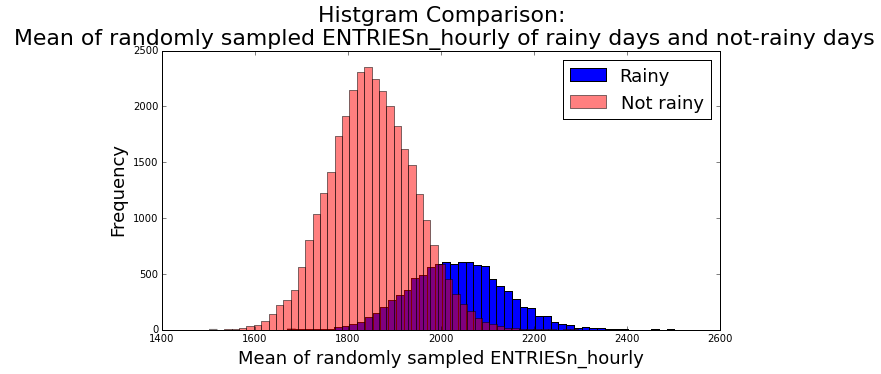

In [724]:
flag = False
r = get_sample_mean(rain)
nr = get_sample_mean(no_rain)

plt.figure(figsize = (10,5))
plt.hist(r,bins=50,normed=flag,color = 'b',label='Rainy')
plt.hist(nr,bins=50,normed=flag,alpha=0.5,color = 'r',label='Not rainy')
plt.legend(fontsize=18)
plt.xlabel('Mean of randomly sampled ENTRIESn_hourly', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Histgram Comparison:\n Mean of randomly sampled ENTRIESn_hourly of rainy days and not-rainy days',fontsize=22)

###### Figure 2. The distribution of mean of randomly sampled two distributions (Rainy vs. not-rainly).

Figure 2 depicts a clearer picture, in which shows the underlying ridership in rainy days is more than that in not-rainy days.  This provides me a further evidence to support my insight (i.e. the ridership in rainy days > the ridership in not-rainy days).

## Section 2. Linear Regression

Though statistical tests are useful, it generally does not reveal the relationship among variables to outcomes. It will be more useful if I can predict the ridership based on some factors (e.g. time). Thus, further analyses are needed.

One of the common approaches is to apply regression, i.e. fitting some mathematical formula to data. The power of regression analysis is to unveil some correlational relationship between outcomes and variables of interest. 

(**Problem 2.1**) Here, I used OLS (Ordinary Least Squared) function from *statsmodels* package to perform regression analysis.  Briefly, OLS is a regression analysis which fits a polynomial function to a given outcome based on selected features by minimizing a particular error (the squared difference in this case) between the predicted outcome and the actual outcome. In this preliminary analysis, I am going to use a linear model (no feature whose power is raised more than one).

In [45]:
#borrowed from Udacity
def normalize_features(df):
    """
    Normalize the features in the data set.
    """
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma

So what kinds of features will be useful to predict *ENTRIESn_hourly*? As a first exploratory model, I like to see a model with only *rain*. The following is the model.


###### Linear model 1: $ENTRIESn\_hourly = intercept + \beta_1*rain$  <a id='model1'></a>

In [192]:
#outcome
y = data['ENTRIESn_hourly']

features = pd.DataFrame()

#features selection 
features['rain'] = data['rain'] ##categorical
features['intercept'] = np.ones(len(data['rain']))

#model fit
model = smf.ols('ENTRIESn_hourly ~ C(rain)',data = data,).fit()

#summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.43
Date:                Wed, 01 Apr 2015   Prob (F-statistic):           9.78e-08
Time:                        18:07:32   Log-Likelihood:            -3.9974e+05
No. Observations:               42480   AIC:                         7.995e+05
Df Residuals:                   42478   BIC:                         7.995e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     1852.9368     16.283    113.796      0.000      1821.022  1884.852
C(rain)[T.1]   183.1188     34.345      5.332      0.000       115.801   250.437
==============================================================================
Omnibus:                    35851.151   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1060832.602
Skew:                           4.018   Prob(JB):                         0.00
Kurtosis:                      26.125   Cond. No.                         2.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model,
$$
ENTRIESn\_hourly =  \left\{
\begin{array}{l l} 
    intercept & \quad \text{if $rain$ = 0}\\
    intercept + \beta_1 & \quad \text{if $rain$ = 1}
\end{array} \right.\
$$

provides information about an effect of *rain* in the presence of averaged effects of others. The result suggests that raining effect on the ridership expects increase by $\beta_1$ (≈ 184 riders), which is not significant if I compare it with range of *ENTRIESn_hourly* shown in [(Figure 1)](#fig1). Also, the quality of the model (**R-squared** = 0.001) shows that *rain* is not a significantly informative predictor of the ridership.

**Note**: It is also interesting to point out that closer examinations of the coefficients reveals that **intercept** is exactly same as mean of the distribution of non-rainy days, and **rain** is the difference of mean between the two distributions [(rainy vs. not-rainy)](#welch). This means that the univariate (only *rain* in the model) is essentially performing t-test on the difference in mean of two distributions.



(**Problem 2.2 - 2.3**) If *rain* is not a good predictor of the ridership, what will be then the good predictors? Intuitively, I selected 1) *hour*, 2) *weekday*, and 3) *UNIT.*  

The logic behind my choices is the follow: 

- *hour*: Rush-hour is very natual phenomena observed in transportation expecially in large cities, where many people commute. *hour* must be an essential variable in regard to predict the ridership.
    
- *weekday* (categorical): In general, people work during weekdays and have no work (or less frequent work) during weekends. Similar to *hour*, I guess *weekday* is another essential variable.
    
- *UNIT* (categorical): Locations of stations should heavily reflect to ridership. For example, if a station is in a business district, people will use the subway more likely than a station near a park in weekdays.
    
The results from the OLS model with these features are shown below.

###### Linear model 2: $ENTRIESn\_hourly$ = $intercept$ + $\beta$\*$hour$ +  $A*weekday$  +  $B_i*UNIT _i$

In [253]:
#outcome
y = data['ENTRIESn_hourly']

#features selection
features = data[['hour']]

#Categorical features selection
dummy_units1 = pd.get_dummies(data['UNIT'], prefix='unit')
features = pd.concat([features,dummy_units1],axis = 1)
dummy_units2 = pd.get_dummies(data['weekday'], prefix='weekday')
features = features.join(dummy_units2)

#set baseline model as unit_R003 and weekday = 0
del features['unit_R003'] 
del features['weekday_0'] 
m = len(y)
features['intercept'] = np.ones(m) # Add a column of constant (y intercept)

#model fit
model = sm.OLS(y, features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     163.1
Date:                Thu, 02 Apr 2015   Prob (F-statistic):               0.00
Time:                        15:39:08   Log-Likelihood:            -3.8583e+05
No. Observations:               42480   AIC:                         7.721e+05
Df Residuals:                   42239   BIC:                         7.742e+05
Df Model:                         240                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
hour         123.9063      1.494     82.963      0.000       120.979   126.834
unit_R004    333.6125    230.666      1.446      0.148      -118.497   785.722
unit_R005    333.8569    231.649      1.441      0.150      -120.180   787.894
unit_R006    451.4656    229.092      1.971      0.049         2.440   900.491
unit_R007    164.7401    232.321      0.709      0.478      -290.615   620.095
unit_R008    173.1874    232.663      0.744      0.457      -282.836   629.211
unit_R009    121.0174    230.666      0.525      0.600      -331.092   573.127
unit_R011   7161.5329    227.886     31.426      0.000      6714.872  7608.194
unit_R012   8505.3555    227.301     37.419      0.000      8059.841  8950.870
unit_R013   2403.7963    227.301     10.575      0.000      1958.282  2849.311
unit_R016    591.8046    227.886      2.597      0.009       145.143  1038.466
unit_R017   4018.7909    227.301     17.680      0.000      3573.277  4464.305
unit_R018   7608.3842    227.592     33.430      0.000      7162.299  8054.469
unit_R019   3072.6834    227.301     13.518      0.000      2627.169  3518.198
unit_R020   6194.8877    227.301     27.254      0.000      5749.373  6640.402
unit_R021   4515.8494    227.886     19.816      0.000      4069.188  4962.511
unit_R022   9339.2802    227.301     41.088      0.000      8893.766  9784.794
unit_R023   5974.4576    227.301     26.284      0.000      5528.943  6419.972
unit_R024   3039.1422    227.592     13.353      0.000      2593.057  3485.228
unit_R025   5169.5759    227.301     22.743      0.000      4724.062  5615.090
unit_R027   2788.8931    227.301     12.270      0.000      2343.379  3234.407
unit_R029   7050.8662    227.301     31.020      0.000      6605.352  7496.380
unit_R030   2921.0598    227.301     12.851      0.000      2475.546  3366.574
unit_R031   4172.8286    227.301     18.358      0.000      3727.314  4618.343
unit_R032   4271.8720    227.592     18.770      0.000      3825.787  4717.957
unit_R033   8055.8393    227.301     35.441      0.000      7610.325  8501.354
unit_R034   1002.3347    232.322      4.314      0.000       546.980  1457.690
unit_R035   2626.5438    227.886     11.526      0.000      2179.882  3073.205
unit_R036    596.2360    230.027      2.592      0.010       145.379  1047.093
unit_R037    682.0860    228.183      2.989      0.003       234.842  1129.330
unit_R038     45.5200    230.666      0.197      0.844      -406.590   497.630
unit_R039    613.8222    233.709      2.626      0.009       155.748  1071.896
unit_R040   1083.4418    227.886      4.754      0.000       636.780  1530.103
unit_R041   2920.8716    227.301     12.850      0.000      2475.357  3366.386
unit_R042    434.5547    229.092      1.897      0.058       -14.469   883.579
unit_R043   2708.0060    227.301     11.914      0.000      2262.492  3153.520
un

(**Problem 2.5 - 2.6**)

This model,
$$
ENTRIESn\_hourly =  \left\{
\begin{array}{l l} 
intercept + \beta*hour & \quad \text{if UNIT = R003 and weekday = 0}\\
intercept + \beta*hour + A*weekday & \quad \text{if UNIT = R003 and weekday = 1}\\
intercept + \beta*hour + B_{i} * UNIT_i& \quad \text{if UNIT = i and weekday = 0}\\
intercept + \beta*hour + A*weekday + B_i * UNIT_i& \quad \text{if UNIT = i and weekday = 1}
\end{array}
\right.\
$$

provides far better fitting results than [the model 1](#model1) (**R-squared**: 0.481 vs. 0.001). Note that $\beta$, A, and B are the associated coefficient from the model.  

However, compared to a model with **R-squared** being 1 (i.e. 100% predictive model), the current model can explain only half of the ridership phenomena and the other half remains still unknown. 

Since I did not take any weather information into account, I am going to see whether any weather information can add predictive power to the current model. 


Here I add daily average of

    - tempreture, 
    - precipitation, 
    - pressure,
    - wind strength 
information upon the model 2, and the results are shown below. 

<a id='model3'></a>
###### Linear model 3: $ENTRIESn\_hourly$ = $intercept$ + $\beta_1$\*$hour$ + $\beta_2$\*$meanprecipi$ + $\beta_3$\*$meantempi$ + $\beta_4$\*$meanwspdi$ + $\beta_5$\*$meanpressurei$ + $A*weekday$  +  $B_i*UNIT _i$ 

In [497]:
#outcome
y = data['ENTRIESn_hourly']

#features selection
features = data[['hour','meanprecipi','meantempi','meanwspdi','meanpressurei']]
# features, m, s = normalize_features(features)

#Categorical features selection
dummy_units1 = pd.get_dummies(data['UNIT'], prefix='unit')
features = pd.concat([features,dummy_units1],axis = 1)
dummy_units2 = pd.get_dummies(data['weekday'], prefix='weekday')
features = features.join(dummy_units2)
# dummy_units3 = pd.get_dummies(data['rain'], prefix='rain')
# features = features.join(dummy_units3)

#set baseline as unit_R003 and weekday = 0 & prevent collinearity 
del features['unit_R003'] 
del features['weekday_0'] 
# del features['rain_0']
m = len(y)
features['intercept'] = np.ones(m) # Add a column of constant (y intercept)

#model fit
model = sm.OLS(y, features).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     161.2
Date:                Fri, 03 Apr 2015   Prob (F-statistic):               0.00
Time:                        16:50:38   Log-Likelihood:            -3.8577e+05
No. Observations:               42480   AIC:                         7.720e+05
Df Residuals:                   42235   BIC:                         7.742e+05
Df Model:                         244                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
hour            123.9195      1.492     83.073      0.000       120.996   126.843
meanprecipi     256.5141    747.955      0.343      0.732     -1209.492  1722.520
meantempi       -14.1474      1.551     -9.124      0.000       -17.186   -11.108
meanwspdi       -15.5171      4.864     -3.190      0.001       -25.051    -5.984
meanpressurei  -374.8412     80.170     -4.676      0.000      -531.977  -217.706
unit_R004       342.9987    230.401      1.489      0.137      -108.591   794.589
unit_R005       338.1200    231.382      1.461      0.144      -115.393   791.633
unit_R006       461.6225    228.836      2.017      0.044        13.099   910.146
unit_R007       174.3410    232.060      0.751      0.452      -280.501   629.183
unit_R008       180.4752    232.395      0.777      0.437      -275.024   635.974
unit_R009       128.7414    230.404      0.559      0.576      -322.855   580.337
unit_R011      7117.2658    228.531     31.144      0.000      6669.341  7565.190
unit_R012      8460.3866    227.944     37.116      0.000      8013.613  8907.161
unit_R013      2358.8275    227.944     10.348      0.000      1912.054  2805.601
unit_R016       546.7547    228.536      2.392      0.017        98.819   994.691
unit_R017      3973.8221    227.944     17.433      0.000      3527.048  4420.596
unit_R018      7608.3597    227.315     33.471      0.000      7162.817  8053.902
unit_R019      3081.9325    227.045     13.574      0.000      2636.919  3526.946
unit_R020      6149.9189    227.944     26.980      0.000      5703.145  6596.693
unit_R021      4471.2154    228.531     19.565      0.000      4023.290  4919.140
unit_R022      9294.3114    227.944     40.775      0.000      8847.537  9741.085
unit_R023      5929.4888    227.944     26.013      0.000      5482.715  6376.263
unit_R024      3048.1679    227.336     13.408      0.000      2602.585  3493.751
unit_R025      5178.8249    227.045     22.810      0.000      4733.811  5623.839
unit_R027      2743.9243    227.944     12.038      0.000      2297.150  3190.698
unit_R029      7005.8974    227.944     30.735      0.000      6559.123  7452.671
unit_R030      2876.0909    227.944     12.618      0.000      2429.317  3322.865
unit_R031      4127.8598    227.944     18.109      0.000      3681.086  4574.634
unit_R032      4227.4893    228.229     18.523      0.000      3780.155  4674.823
unit_R033      8010.8705    227.944     35.144      0.000      7564.097  8457.644
unit_R034       956.7683    232.887      4.108      0.000       500.306  1413.231
unit_R035      2582.4220    228.520     11.301      0.000      2134.518  3030.326
unit_R036       596.4265    229.746      2.596      0.009       146.120  1046.734
unit_R037       681.9059    227.906      2.992      0.003       235.205  1128.607
unit_R038        48.7333    230.386      0.212   

The improvement from model 2 to model 3 is not as dramatic as the one seen from model 1 to model 2. The improvement is rather neglegible (**R-squared**: 0.481 to 0.482). This suggests me that the predictive factors in the ridership rely less on the weather and more on non-weather elements (e.g. time, station locations, $etc.$). 

Lastly, from model 1 to model 3, where I only consider a linear model with additive element, the model can only have approximately 50% predictive capability. This indicates that I need to consider more complex elements/model in order to approximate the ridership better. 

(**Problem 2.4**)
The resultant coefficients of non-categorical variables of [model 3](#model3) are:
- *hour*: 123.9195
- *meanprecipi*: 256.5141 (*statistically not significant)
- *meantempi*: -14.1474
- *meanwspdi*: -15.5171
- *meanpressurei*: -374.8421


## Section 3. Visualization

Visualization is another important aspect of data science. I can simply present numbers after numbers, but such presentation is hard for audience to understand indications. To understand the effect of rain on the ridership, I made several plots.

(**Problem 3.1**) One plot is already shown in [Figure 1](#fig1), where I concluded the ridership in rainy days may be higher than that in not-rainy days.

(**Problem 3.2**) From Section 2, I found out the ridership relies more on non-weather factors than the weather factors. In the following figure, I capture how the ridership depends on rain and day of a week. <a id='fig3'></a>

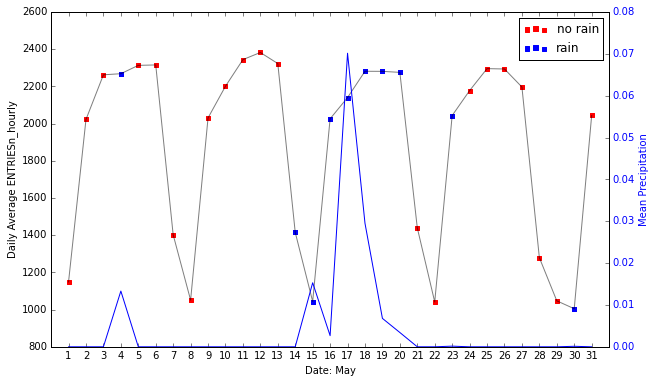

In [699]:
ENTRIESn_hourly_dailymean = np.array([i['ENTRIESn_hourly'].mean() for group, i in data.groupby('DATEn')])
rain_mean = np.array([i['rain'].mean() for group, i in data.groupby('DATEn')])
meanprecipi = np.array([i['meanprecipi'].mean() for group, i in data.groupby('DATEn')])
date = np.arange(len(set(data['DATEn'])))

fig, ax1 = plt.subplots(figsize = (10,6))

ax1.plot(date,ENTRIESn_hourly_dailymean,'k-',alpha = 0.5)
h1 = ax1.scatter(date,ENTRIESn_hourly_dailymean,color = 'r',marker = 's')

for ind,i in enumerate(rain_mean):
    if i > 0:
        h2 = ax1.scatter(date[ind],ENTRIESn_hourly_dailymean[ind],color = 'b',marker = 's')

ax1.legend([h1,h2],['no rain','rain'])
ax1.set_ylabel('Daily Average ENTRIESn_hourly')
        
ax2 = ax1.twinx()
ax2.plot(date,mean_precipi,'b')
ax2.set_ylabel('Mean Precipitation',color = 'b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    
plt.xlim([-1,31])
plt.xticks(np.arange(31),np.arange(31)+1)
ax1.set_xlabel('Date: May')

###### Figure 3. Time evolution of daily-average ENTRIESn-hourly with an associated precipitation history.

The overall trend is very consistent regardless of rain status. Daily-averaged ridership is high  throughout weekdays, and is low during weekends (May 1 was Sunday). 

The another aspect, by aligning day of a week, of the same figure is shown below.


In [678]:
#make 7 days x 5 weeks array to plot
array = np.append(ENTRIESn_hourly_dailymean, [0]*(35-len(ENTRIESn_hourly_dailymean))).reshape((5,7))
rain_mask = np.append(rain_mean, [0]*(35-len(ENTRIESn_hourly_dailymean))).reshape((5,7))

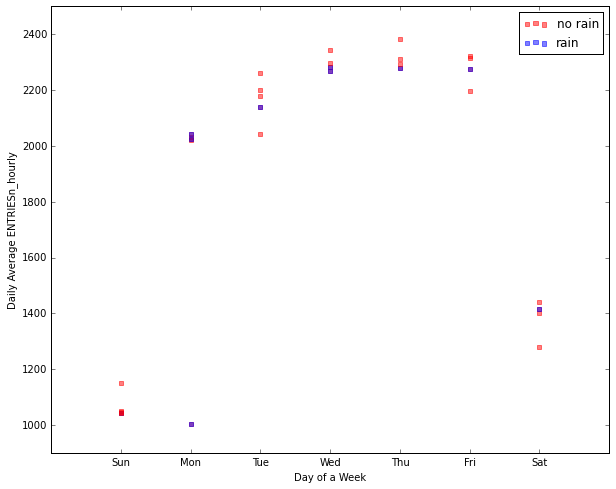

In [703]:
plt.subplots(figsize = (10,8))
for value, mask in zip(array,rain_mask):
    h1 = plt.scatter(np.arange(7),np.atleast_1d(value),color = 'r',marker = 's',alpha = 0.5)
    h2 = plt.scatter(np.arange(7)[mask > 0], value[mask > 0],color = 'b',marker = 's',alpha = 0.5)
plt.legend([h1,h2], ['no rain','rain'])
plt.xlim([-1,7])
plt.ylim([900,2500])
plt.xlabel('Day of a Week')
plt.xticks(np.arange(8),['Sun','Mon','Tue','Wed','Thu','Fri','Sat',''])
plt.ylabel('Daily Average ENTRIESn_hourly')

###### Figure 4. Time evolution of daily-average ENTRIESn-hourly with an associated precipitation history aligned by day of a week. <a id = 'fig4'></a>

Here are some observations I make:
- Clearly, daily-averaged ridership follows a noticeable pattern, which behaves quadratic-like manner.
- The range of daily-averaged ridership for each day is highly consistent regardless of rain condition. Note that though one data from Monday resides far outside compared with other data, that Monday (May 30th from [Figure 3](#fig3)) was Memorial day. Thus, the ridership on May 30th rather behaved like one on Sunday.


## Section 5. Reflection

(**Problem 5.1 - 5.2**) There are many shortcomings and insight gained in this analysis. 

1) the real ridership cannot be simply predicted by a linear function. In fact, Section 2. proved that the OLS model with the current features was not doing a good job. The real world is far more complicated. My model only takes account independent effect of factors, and I must consider the effect of their interactions. 

For example, rain may effect differently depends on a location of a station. Small stations may not be influenced by rain because they may be located in remote area, whereas big stations may also not be influenced because people need to use the subway anyway to commute. So medium stations may be influenced the most.  

Another example, as I briefly mentioned in [Figure 4](#fig4), the ridership depends on days of a week rather quadratically. This suggests that a factor can interact even with itself.

In short, there are many factors and interactions I need to consider in order to predict and understand the ridership in NYC. 

2) I have only analyzed one-month-worth data. If I were to make the subway usage more predictable and infer the relationship between the ridership and rain, I must consider acquiring more data. There may be seasonal trend in the ridership, and the ridership in general may change from one to another. 

With these in my mind, I performed another OLS model with some interaction effects (higher order *hour*, higher order *day_week*, and interaction between *rain* and *UNIT*).



OLS Model: $ENTRIESn\_hourly = intercept + \beta_1*hour + \beta_2*hour^2 + \beta_3*hour^3 + \beta_4*day\_week + \beta_5*day\_week^2 + A*UNIT + B*rain + C*UNIT*rain$ <a id = 'ols'></a>

In [40]:
# formula
formula = 'ENTRIESn_hourly ~ C(UNIT)*C(rain) + hour + np.power(hour,2) + np.power(hour,3) + day_week + np.power(day_week,2)'

# model fit
model = smf.ols(formula,data).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     91.85
Date:                Sat, 04 Apr 2015   Prob (F-statistic):               0.00
Time:                        15:37:43   Log-Likelihood:            -3.8447e+05
No. Observations:               42480   AIC:                         7.699e+05
Df Residuals:                   41997   BIC:                         7.741e+05
Df Model:                         482                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                     -370.5028    184.819     -2.005      0.045      -732.753    -8.253
C(UNIT)[T.R004]                341.3739    254.471      1.342      0.180      -157.395   840.143
C(UNIT)[T.R005]                328.1435    254.020      1.292      0.196      -169.742   826.029
C(UNIT)[T.R006]                499.0854    254.032      1.965      0.049         1.177   996.993
C(UNIT)[T.R007]                139.6496    257.773      0.542      0.588      -365.590   644.889
C(UNIT)[T.R008]                160.8575    257.280      0.625      0.532      -343.416   665.131
C(UNIT)[T.R009]                142.9873    256.319      0.558      0.577      -359.404   645.378
C(UNIT)[T.R011]               6865.3622    252.288     27.212      0.000      6370.873  7359.852
C(UNIT)[T.R012]               8200.8334    251.454     32.614      0.000      7707.979  8693.688
C(UNIT)[T.R013]               2357.6459    251.454      9.376      0.000      1864.791  2850.501
C(UNIT)[T.R016]                596.1609    252.288      2.363      0.018       101.672  1090.650
C(UNIT)[T.R017]               3847.5139    251.454     15.301      0.000      3354.659  4340.369
C(UNIT)[T.R018]               7652.0268    251.868     30.381      0.000      7158.361  8145.692
C(UNIT)[T.R019]               3120.2131    251.458     12.408      0.000      2627.350  3613.076
C(UNIT)[T.R020]               5885.9514    251.454     23.408      0.000      5393.097  6378.806
C(UNIT)[T.R021]               4391.5542    252.288     17.407      0.000      3897.064  4886.045
C(UNIT)[T.R022]               9252.3820    251.454     36.796      0.000      8759.527  9745.237
C(UNIT)[T.R023]               5877.2501    251.454     23.373      0.000      5384.395  6370.105
C(UNIT)[T.R024]               3095.9793    251.873     12.292      0.000      2602.304  3589.655
C(UNIT)[T.R025]               5273.5047    251.458     20.972      0.000      4780.642  5766.368
C(UNIT)[T.R027]               2685.5070    251.454     10.680      0.000      2192.652  3178.362
C(UNIT)[T.R029]               6846.3612    251.454     27.227      0.000      6353.506  7339.216
C(UNIT)[T.R030]               2845.1181    251.454     11.315      0.000      2352.263  3337.973
C(UNIT)[T.R031]               4087.6667    251.454     16.256      0.000      3594.812  4580.522
C(UNIT)[T.R032]               4116.6727    251.868     16.345      0.000      3623.005  4610.340
C(UNIT)[T.R033]               8031.1320    251.454     31.939      0.000      7538.277  8523.987
C(UNIT)[T.R034]               1014.1125    257.278      3.942      0.000       509.843  1518.382
C(UNIT)[T.R035]               2636.9115    252.288     10.452      0.000      2142.422  3131.401
C(UNIT)[T.R036]                595.3103    255.380      2.331      0.020    

Though it was not drastic improvement and the predictive quality is still approximately 50%, a quality of the model was improved more noticeably than the change seen from model 2 to model 3. Thus, more complex factors are needed in order to predict the ridership with accuracy.

## Section 4. Conclusion 

(**Problem 4.1 - 4.2**) Based on my analysis, I will hypothesize that rainy days increase the ridership due to positive interaction terms from [the last OLS model](#ols). 

For example, for UNIT 012, the model without rain is:
$ENTRIESn\_hourly = -370.5 + \beta_1*hour + \beta_2*hour^2 + \beta_3*hour^3 + \beta_4*day\_week + \beta_5*day\_week^2 + 8200.8$

and with rain is:
$ENTRIESn\_hourly = -370.5 + \beta_1*hour + \beta_2*hour^2 + \beta_3*hour^3 + \beta_4*day\_week + \beta_5*day\_week^2 + 8200.8 - 59.1 + 1542.1 $

This indicates that fixing the effect of all other variables (*hour* and *day_week*), the expected increase in the ridership at UNIT 012 is about 1483 (= 1542.1 - 59.1) riders. 

With this interpretation and the results from Section 2, I claim that more riders is expected for rainy days in average. 

In [41]:
from IPython.core.display import HTML


def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [705]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)